In [1]:
#Install what is needed
!pip install pandas numpy matplotlib xarray hvplot
!pip install rasterio
!pip install rioxarray
!pip install fiona 
!pip install geopandas
!pip install cartopy
!pip install geopandas geoviews
!pip install netCDF4
!pip install pydap
!pip install pygbif
!pip install osmnx
!pip install earthaccess


#Import from installations
import fiona
import os
import pathlib
import hvplot.xarray  
import rioxarray  
import pathlib
import requests
import zipfile
import geopandas as gpd 
import hvplot.pandas
import netCDF4
import earthaccess


import xarray as xr
import geopandas as gpd
import rioxarray as rxr
import matplotlib.pyplot as plt
import geopandas as gpd
import cartopy.crs as ccrsp
import pandas as pd
import numpy as np

from math import floor, ceil
from shapely.geometry import box
from rioxarray.merge import merge_arrays
from osmnx import features as osm
from pygbif import occurrences
from glob import glob
from rioxarray.merge import merge_arrays
from shapely.geometry import Point

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 38.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 161.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.5/29.5 MB 247.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 176.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 142.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.2/17.2 MB 158.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.7/27.7 MB 196.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 245.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 142.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.3/547.3 kB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 140.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 244.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 

In [2]:
# save records into the iplant user
iplant_user = os.environ['IPLANT_USER']
data_path = (
    pathlib.Path.home()
    / 'data-store' / 'home' / iplant_user / 'habitat_suitability')

data_path.mkdir(parents = True, exist_ok = True)

data_path

# Define and create the project data directory
habitat_suitability_data_dir = os.path.join(
    pathlib.Path.home(),
    'earth-analytics',
    'data',
    'habitat_suitability'
)
os.makedirs(habitat_suitability_data_dir, exist_ok=True)

# Call the data directory to check its location
habitat_suitability_data_dir


# ---------------------------------------------------------------------------------------------------------------------------------------------------
# Define correct project directory path
project_data_dir = os.path.join(
    pathlib.Path.home(),
    'Rocky_Mountain_Juniper_Study',
    'data',
    'habitat_suitability'
)
os.makedirs(project_data_dir, exist_ok=True)

print("Data directory is:", project_data_dir)

# Define WKT bounding box for ROMO area
bbox = "POLYGON((-105.9 40.1, -105.4 40.1, -105.4 40.6, -105.9 40.6, -105.9 40.1))"

# Query GBIF for Juniperus scopulorum
records = occurrences.search(
    scientificName="Juniperus scopulorum",
    hasCoordinate=True,
    limit=1000,
    geometry=bbox
)

# ---------------------------------------------------------------------------------------------------------------------------------------------------
# Search Juniperus scopulorum within bounding box (ROMO)
forest_gdf = osm.features_from_place(
    query = 'Roosevelt National Forest',
    tags = {'name':'Roosevelt National Forest'})

# ---------------------------------------------------------------------------------------------------------------------------------------------------
forest_gdf = forest_gdf.iloc[[0]]

# ---------------------------------------------------------------------------------------------------------------------------------------------------
# Convert GBIF records (list of dicts) to DataFrame
juniper_gdf = gpd.read_file ('Juniper_Occur.zip')

juniper_gdf.eventDate = pd.to_datetime(juniper_gdf.eventDate , format='ISO8601', utc=True)

# Drop rows without lat/lon
juniper_gdf = juniper_gdf.dropna(subset=["decimalLatitude", "decimalLongitude","eventDate"])

juniper_gdf = (
    gpd.GeoDataFrame(
        juniper_gdf, 
        geometry=gpd.points_from_xy(
            juniper_gdf.decimalLongitude, 
            juniper_gdf.decimalLatitude), 
        crs="EPSG:4326")
    # Select the desired columns
    [['eventDate','geometry']]
)

# ---------------------------------------------------------------------------------------------------------------------------------------------------
# Ensure both are in EPSG:4326 for web maps
forest_gdf = forest_gdf.to_crs("EPSG:4326")
juniper_gdf = juniper_gdf.to_crs("EPSG:4326")

juniper_occur_gdf = juniper_gdf.sjoin(
    gpd.GeoDataFrame(
        geometry = forest_gdf.envelope),
    predicate = 'within')

Data directory is: /home/jovyan/Rocky_Mountain_Juniper_Study/data/habitat_suitability


In [3]:
# ROMO boundary plot 
forest_plot = forest_gdf.hvplot(
    geo=True,
    line_color='white',
    line_width=4,
    fill_alpha=0,           # Make polygon fill transparent
    alpha=0.7,
    tiles='EsriImagery',  
    frame_width=400,
    frame_height=800,
    title="Juniperus scopulorum in Roosevelt National Forest"
)

# GBIF points 
juniper_plot = juniper_occur_gdf.hvplot.points(
    geo=True,
    color='red',
    size=10,
    alpha=0.6
)



In [4]:
# Process POLARIS Raster Image Part 1 of 2

# Create function with description to process raster images
def process_image(url, soil_prop, soil_stat, soil_depth, bounds_gdf):
    """
    Load, crop, and scale raster images for multiple sites.

    Parameters
    ----------
    url: str
      URL or path for raster files.
    soil_prop: str
      Soil property (e.g., "sand", "clay", etc.)
    soil_stat: str
      Soil statistic (e.g., "mean", "median", etc.)
    soil_depth: str
      Soil depth (e.g., "30-60cm", "60-100cm", etc.)
    bounds_gdf: gpd.GeoDataFrame
      Area of interest to crop to.
    site_names: list
      List of site names to be used as dictionary keys.
    Returns
    -------
   merged_da: rxr.DataArray
      Processed rasters 
    """

    # Iterate through the list of bounding GeoDataFrames (areas of interest)
    #for site_name, bounds_gdf in zip(site_names, bounds_gdfs):

    # Get the study bounds
    bounds_min_lon, bounds_min_lat, bounds_max_lon, bounds_max_lat = (
    bounds_gdf
    .to_crs(4326)
    .total_bounds 
    )

    # List to store cropped DataArrays for the current site
    da_list = []
    
    # Loop through bounding box coordinates
    for min_lon in range(floor(bounds_min_lon), ceil(bounds_max_lon)):
      for min_lat in range(floor(bounds_min_lat), ceil(bounds_max_lat)):

        # Format the URL with the current coordinates and other parameters
        formated_url = (
          url.format( 
              soil_prop = soil_prop, 
              soil_stat = soil_stat, 
              soil_depth = soil_depth,
              min_lat=min_lat , max_lat=min_lat+1,
              min_lon=min_lon, max_lon=min_lon+1 )
        )

        # Connect to the raster image
        da = rxr.open_rasterio(
        formated_url, 
        mask_and_scale=True
        ).squeeze()
        
        # Crop the raster image to the bounds of the study area
        cropped_da = (
        da.rio.clip_box(bounds_min_lon, bounds_min_lat, bounds_max_lon, bounds_max_lat)
        )

        # Append the cropped DataArray to the list
        da_list.append(cropped_da)   

    # Merge the cropped DataArrays for this site
    merged_da = merge_arrays(da_list)

    return merged_da

In [5]:
# Process POLARIS raster image part 2 of 2
# Test the function by defining variables and plotting

# Set the site parameters
# soil variables
soil_prop = 'ph'
soil_stat = 'mean'
soil_depth = '60_100'
# set up url template
soil_url_template = (
            "http://hydrology.cee.duke.edu"
            "/POLARIS/PROPERTIES/v1.0"
            "/{soil_prop}"
            "/{soil_stat}"
            "/{soil_depth}"
            "/lat{min_lat}{max_lat}_lon{min_lon}{max_lon}.tif"
            )

# bounds
forest_bounds_gdfs = [forest_gdf]

# output_directory - create data dir for polaris data 
pH_dir= os.path.join(habitat_suitability_data_dir, 'pH')
os.makedirs(pH_dir, exist_ok=True)

In [6]:
# Create new variables for each study area using the process_image function

#Comanche National Grassland
pH_processed = (process_image(
    soil_url_template,
    soil_prop, soil_stat, soil_depth,
    juniper_occur_gdf
))


# Create a list to save both previous polaris processed study areas
pH_processed_da_list = [
pH_processed]

# Call the list to make sure it worked/looks right
#pH_processed_da_list

[Text(0.5, 1.0, 'Juniper Occurences - pH'),
 Text(0.5, 23.52222222222222, 'Longitude'),
 Text(169.45921033104074, 0.5, 'Latitude')]

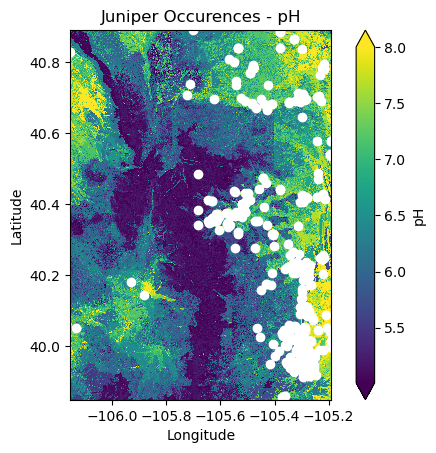

In [7]:
reprojpH_gdf = juniper_occur_gdf.to_crs(pH_processed.rio.crs)

# Plot Pawnee to make sure it works/ looks right
pH_processed.plot(
    cbar_kwargs={"label": "pH"},
    robust=True,
    )

juniper_occur_gdf.to_crs(pH_processed.rio.crs).plot(
    ax=plt.gca(),
    color='white').set(
        title='Juniper Occurences - pH',
        xlabel='Longitude', 
        ylabel='Latitude',
    )
#plt.show()

In [8]:
# POLARIS soil composition

# Set the site parameters
# soil variables
soil_prop = 'clay'
soil_stat = 'mean'
soil_depth = '60_100'

# bounds
forest_bounds_gdfs = [forest_gdf]

# output_directory - create data dir for polaris data 
clay_dir= os.path.join(habitat_suitability_data_dir, 'clay')
os.makedirs(clay_dir, exist_ok=True)

In [9]:
# Create new variables for each study area using the process_image function

#Comanche National Grassland
clay_processed = (process_image(
    soil_url_template,
    soil_prop, soil_stat, soil_depth,
    juniper_occur_gdf
))


# Create a list to save both previous polaris processed study areas
clay_processed_da_list = [
clay_processed]

# Call the list to make sure it worked/looks right
#clay_processed_da_list

[Text(0.5, 1.0, 'Juniper Occurences - % clay'),
 Text(0.5, 23.52222222222222, 'Longitude'),
 Text(169.45921033104074, 0.5, 'Latitude')]

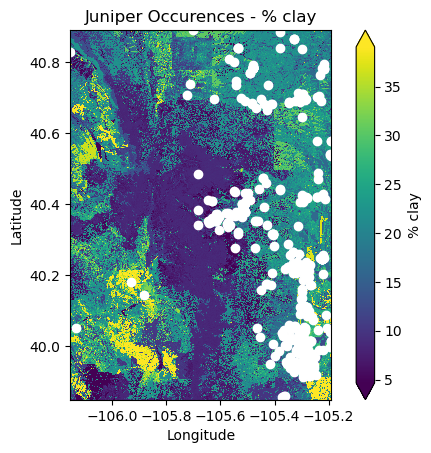

In [10]:
reprojclay_gdf = juniper_occur_gdf.to_crs(clay_processed.rio.crs)

# Plot Pawnee to make sure it works/ looks right
clay_processed.plot(
    cbar_kwargs={"label": "% clay"},
    robust=True,
    )

juniper_occur_gdf.to_crs(clay_processed.rio.crs).plot(
    ax=plt.gca(),
    color='white').set(
        title='Juniper Occurences - % clay',
        xlabel='Longitude', 
        ylabel='Latitude',
    )
#plt.show()

In [11]:
# POLARIS soil composition

# Set the site parameters
# soil variables
soil_prop = 'sand'
soil_stat = 'mean'
soil_depth = '60_100'

# bounds
forest_bounds_gdfs = [forest_gdf]

# output_directory - create data dir for polaris data 
sand_dir= os.path.join(habitat_suitability_data_dir, 'sand')
os.makedirs(sand_dir, exist_ok=True)

In [12]:
# Create new variables for each study area using the process_image function

#Comanche National Grassland
sand_processed = (process_image(
    soil_url_template,
    soil_prop, soil_stat, soil_depth,
    juniper_occur_gdf
))


# Create a list to save both previous polaris processed study areas
sand_processed_da_list = [
sand_processed]

# Call the list to make sure it worked/looks right
#sand_processed_da_list

[Text(0.5, 1.0, 'Juniper Occurences - % sand'),
 Text(0.5, 23.52222222222222, 'Longitude'),
 Text(169.45921033104074, 0.5, 'Latitude')]

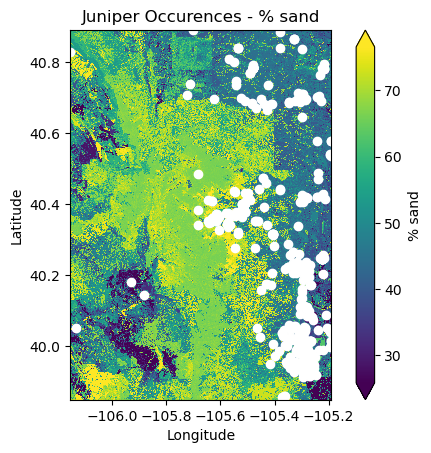

In [13]:
reprojsand_gdf = juniper_occur_gdf.to_crs(sand_processed.rio.crs)

# Plot Pawnee to make sure it works/ looks right
sand_processed.plot(
    cbar_kwargs={"label": "% sand"},
    robust=True,
    )

juniper_occur_gdf.to_crs(sand_processed.rio.crs).plot(
    ax=plt.gca(),
    color='white').set(
        title='Juniper Occurences - % sand',
        xlabel='Longitude', 
        ylabel='Latitude',
    )
#plt.show()

In [14]:
# Prep for downloading SRTM 

# Define and create the project data directory
habitat_suitability_data_dir = os.path.join(
    pathlib.Path.home(),
    'earth-analytics',
    'data',
    'habitat_suitability'
)
os.makedirs(habitat_suitability_data_dir, exist_ok=True)

# Call the data directory to check its location
habitat_suitability_data_dir

# Create data dir 
elevation_dir= os.path.join(habitat_suitability_data_dir, 'srtm')
os.makedirs(elevation_dir, exist_ok=True)

# call the variable to check location
elevation_dir

'/home/jovyan/earth-analytics/data/habitat_suitability/srtm'

In [15]:
# Download Raster data through earthaccess Part 1 of 1
# Login and search earthaccess, download results

# login to earthaccess
earthaccess.login(strategy="interactive", persist=True)

bounds = tuple(forest_gdf.total_bounds)

# Search earthaccess
elevation_results = earthaccess.search_data(
    short_name = "SRTMGL1",
    bounding_box = bounds
)
elevation_results

# Download earthaccess results
srtm_files = earthaccess.download(elevation_results, elevation_dir)

# Return a list of file paths that match the pattern
srtm_files = glob (os.path.join(
    elevation_dir, 
    '*hgt.zip')
)

# Call srtm_file to see it 
srtm_files

Enter your Earthdata Login username:  el3branr0cks
Enter your Earthdata password:  ········


INFO:You're now authenticated with NASA Earthdata Login
INFO:Persisting credentials to /home/jovyan/.netrc
INFO:Granules found: 4
INFO: Getting 4 granules, approx download size: 0.05 GB


QUEUEING TASKS | :   0%|          | 0/4 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/4 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/4 [00:00<?, ?it/s]

['/home/jovyan/earth-analytics/data/habitat_suitability/srtm/N40W106.SRTMGL1.hgt.zip',
 '/home/jovyan/earth-analytics/data/habitat_suitability/srtm/N40W107.SRTMGL1.hgt.zip',
 '/home/jovyan/earth-analytics/data/habitat_suitability/srtm/N39W107.SRTMGL1.hgt.zip',
 '/home/jovyan/earth-analytics/data/habitat_suitability/srtm/N39W106.SRTMGL1.hgt.zip']

In [16]:
# Create list of files for each study area
juniper_srtm_files = list(srtm_files)

# Call list to make sure it's right
juniper_srtm_files

['/home/jovyan/earth-analytics/data/habitat_suitability/srtm/N40W106.SRTMGL1.hgt.zip',
 '/home/jovyan/earth-analytics/data/habitat_suitability/srtm/N40W107.SRTMGL1.hgt.zip',
 '/home/jovyan/earth-analytics/data/habitat_suitability/srtm/N39W107.SRTMGL1.hgt.zip',
 '/home/jovyan/earth-analytics/data/habitat_suitability/srtm/N39W106.SRTMGL1.hgt.zip']

In [17]:
# Create function with description to process srtm raster images
# Part 1 of 1
def process_image_list(url_list, chosen_buffer, bounds_gdf):
    """
    Load, crop, and scale a raster image 

    Parameters
    ----------
    url: file-like or path-like
      File accessor downloaded or obtained 
    chosen_buffer: float number
      Amount of degrees to extend past the bounds of the bounds_gdf 
    bounds_gdf: gpd.GeoDataFrame
      Area of interest to crop to

    Returns
    -------
    merged_da: rxr.DataArray
      Processed raster
    """   
        
    # List to store cropped DataArrays for the current site 
    da_list= []
      
    buffer= chosen_buffer

    for url in url_list:

        # Connect to the raster image
        da = rxr.open_rasterio(
          url, 
          mask_and_scale=True
          ).squeeze()
        
          # Get the study bounds
        bounds_min_lon, bounds_min_lat, bounds_max_lon, bounds_max_lat = (
          bounds_gdf
          .to_crs(da.rio.crs)
          .total_bounds 
          )

        # Crop the raster image to the bounds of the study area
        cropped_da = (
          da.rio.clip_box(bounds_min_lon-buffer, bounds_min_lat-buffer, bounds_max_lon+buffer, bounds_max_lat+buffer)
          )
        
        # Append the cropped DataArray to the list
        da_list.append(cropped_da)

    # Merge the cropped DataArrays for this site
    merged_da = (
      merge_arrays(da_list)
      )
        
    return merged_da

In [18]:
# Use process_image_list function on each set of site files 
# save to new variable names to use later

# Use process_image_list function on comanche srtm files
srtm_juniper_result_da = process_image_list(juniper_srtm_files, .025, forest_gdf)


# Create a list to save the site srtm results to
srtm_da_results = [
    srtm_juniper_result_da,
]
srtm_da_results

print("Raster CRS:", srtm_juniper_result_da.rio.crs)
print("GDF CRS:", juniper_occur_gdf.crs)

juniper_occur_gdf = juniper_occur_gdf[juniper_occur_gdf.geometry.notnull() & juniper_occur_gdf.is_valid]
forest_gdf = forest_gdf[forest_gdf.geometry.notnull() & forest_gdf.is_valid]

print("Juniper GDF bounds:", juniper_occur_gdf.total_bounds)
print("RNF GDF bounds:", forest_gdf.total_bounds)
# Reproject vector to match raster
juniper_occur_gdf = juniper_occur_gdf.to_crs(srtm_juniper_result_da.rio.crs)

Raster CRS: EPSG:4326
GDF CRS: EPSG:4326
Juniper GDF bounds: [-106.15445    39.849905 -105.190508   40.89    ]
RNF GDF bounds: [-106.195438    39.8470609 -105.1901814   40.997754 ]


In [19]:
forest_gdf

,,type,boundary,name,operator,operator:short,operator:type,operator:wikidata,operator:wikipedia,ownership,protect_class,protected,protected_area,protection_title,website,wikidata,wikipedia,geometry
element,id,,,,,,,,,,,,,,,,,
relation,395767,boundary,protected_area,Roosevelt National Forest,United States Forest Service,USFS,public,Q1891156,en:United States Forest Service,national,6,perpetuity,forest_reserve,National Forest,https://www.fs.usda.gov/arp,Q7366477,en:Roosevelt National Forest,"MULTIPOLYGON (((-106.15924 40.99745, -106.1445..."


/opt/conda/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


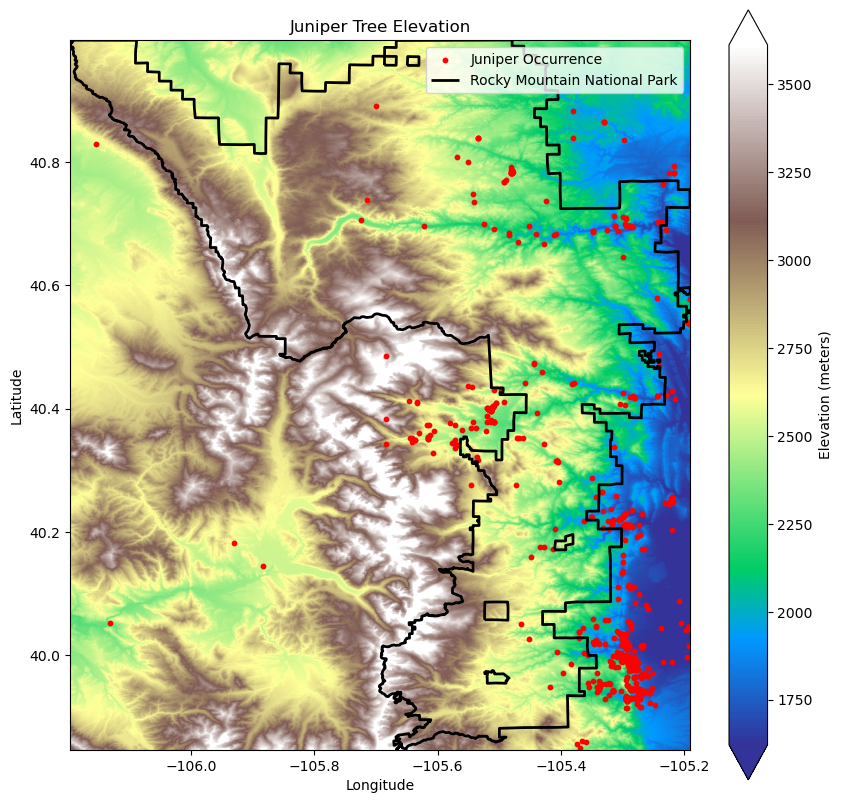

In [20]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))

# Plot raster
srtm_juniper_result_da.plot(
    ax=ax,
    cmap='terrain',
    robust=True,
    cbar_kwargs={"label": "Elevation (meters)"}
)

if juniper_gdf.geometry.iloc[0].geom_type == "Point":
    juniper_gdf.plot(ax=ax, color='red', markersize=10, label='Juniper Occurrence')
else:
    juniper_gdf.boundary.plot(ax=ax, color='red', linewidth=1, label='Juniper Boundary')

# Plot Boulder boundary
forest_gdf.boundary.plot(ax=ax, color='black', linewidth=2, label='Rocky Mountain National Park')

# Set valid aspect ratio
ax.set_aspect('equal')  
b_box = forest_gdf.total_bounds
ax.set_xlim(b_box[0],b_box[2])
ax.set_ylim(b_box[1],b_box[3])


# Label the axes
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Add title, legend, and formatting
ax.set_title("Juniper Tree Elevation")
ax.legend()

#plt.tight_layout()
#plt.show()

In [52]:
# def convert_longitude(longitude):
def convert_longitude(longitude):
    """ Convert logitude range from  0-360 to -180-180"""
    return (longitude - 360) if longitude > 180 else longitude

maca_da_list = []

# Define time windows (start year only, end = start+4)
start_years = [2035, 2065]  
scenario = 'rcp45'  # fixed scenario

for site_name, gdf in {'Roosevelt National Forest': forest_gdf}.items():
    for variable in ['pr']:
        for start_year in start_years:
            end_year = start_year - 30
            maca_url = (
                'http://thredds.northwestknowledge.net:8080/thredds/dodsC/agg_macav2metdata_pr_BNU-ESM_r1i1p1_rcp45_2006_2099_CONUS_monthly.nc'
            )
            print(f"Trying: {maca_url}")
            try:
                ds = xr.open_dataset(maca_url)
                maca_da = ds.squeeze().precipitation

                # Convert longitudes
                maca_da = maca_da.assign_coords(
                    lon=('lon', [convert_longitude(l) for l in maca_da.lon.values])
                )

                # Set spatial dimensions
                maca_da = maca_da.rio.set_spatial_dims(x_dim='lon', y_dim='lat')

                # Get bounds in same CRS as MACA
                bounds = gdf.to_crs(maca_da.rio.crs).total_bounds

                # Clip to site bounds
                maca_da = maca_da.rio.clip_box(*bounds)

                # Save to list
                maca_da_list.append(dict(
                    site_name=site_name,
                    variable=variable,
                    scenario=scenario,
                    start_year=start_year,
                    da=maca_da
                ))
            except Exception as e:
                print(f"Failed to load {maca_url}: {e}")

# Convert to DataFrame
maca_df = pd.DataFrame(maca_da_list)

# View what we got
maca_df[['da','site_name','variable','start_year']].values

Trying: http://thredds.northwestknowledge.net:8080/thredds/dodsC/agg_macav2metdata_pr_BNU-ESM_r1i1p1_rcp45_2006_2099_CONUS_monthly.nc
Trying: http://thredds.northwestknowledge.net:8080/thredds/dodsC/agg_macav2metdata_pr_BNU-ESM_r1i1p1_rcp45_2006_2099_CONUS_monthly.nc


array([[<xarray.DataArray 'precipitation' (time: 1128, lat: 28, lon: 25)> Size: 3MB
        [789600 values with dtype=float32]
        Coordinates:
          * lat      (lat) float64 224B 39.85 39.9 39.94 39.98 ... 40.9 40.94 40.98
          * time     (time) object 9kB 2006-01-15 00:00:00 ... 2099-12-15 00:00:00
          * lon      (lon) float64 200B -106.2 -106.1 -106.1 ... -105.3 -105.2 -105.2
            crs      int64 8B 0
        Attributes:
            long_name:      Monthly Precipitation Amount
            units:          mm
            standard_name:  precipitation
            cell_methods:   time: sum(interval: 24 hours): sum over days
            comments:       Total monthly precipitation at surface: includes both liq...
            _ChunkSizes:    [ 10  44 107]                                               ,
        'Roosevelt National Forest', 'pr', 2035],
       [<xarray.DataArray 'precipitation' (time: 1128, lat: 28, lon: 25)> Size: 3MB
        [789600 values with dty

In [53]:
[display(row) for row in maca_da_list]

{'site_name': 'Roosevelt National Forest',
 'variable': 'pr',
 'scenario': 'rcp45',
 'start_year': 2035,
 'da': <xarray.DataArray 'precipitation' (time: 1128, lat: 28, lon: 25)> Size: 3MB
 [789600 values with dtype=float32]
 Coordinates:
   * lat      (lat) float64 224B 39.85 39.9 39.94 39.98 ... 40.9 40.94 40.98
   * time     (time) object 9kB 2006-01-15 00:00:00 ... 2099-12-15 00:00:00
   * lon      (lon) float64 200B -106.2 -106.1 -106.1 ... -105.3 -105.2 -105.2
     crs      int64 8B 0
 Attributes:
     long_name:      Monthly Precipitation Amount
     units:          mm
     standard_name:  precipitation
     cell_methods:   time: sum(interval: 24 hours): sum over days
     comments:       Total monthly precipitation at surface: includes both liq...
     _ChunkSizes:    [ 10  44 107]}

{'site_name': 'Roosevelt National Forest',
 'variable': 'pr',
 'scenario': 'rcp45',
 'start_year': 2065,
 'da': <xarray.DataArray 'precipitation' (time: 1128, lat: 28, lon: 25)> Size: 3MB
 [789600 values with dtype=float32]
 Coordinates:
   * lat      (lat) float64 224B 39.85 39.9 39.94 39.98 ... 40.9 40.94 40.98
   * time     (time) object 9kB 2006-01-15 00:00:00 ... 2099-12-15 00:00:00
   * lon      (lon) float64 200B -106.2 -106.1 -106.1 ... -105.3 -105.2 -105.2
     crs      int64 8B 0
 Attributes:
     long_name:      Monthly Precipitation Amount
     units:          mm
     standard_name:  precipitation
     cell_methods:   time: sum(interval: 24 hours): sum over days
     comments:       Total monthly precipitation at surface: includes both liq...
     _ChunkSizes:    [ 10  44 107]}

[None, None]

In [23]:
maca_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   site_name   2 non-null      object
 1   variable    2 non-null      object
 2   scenario    2 non-null      object
 3   start_year  2 non-null      int64 
 4   da          2 non-null      object
dtypes: int64(1), object(4)
memory usage: 212.0+ bytes


In [24]:
maca_df.drop('da', axis='columns')

,site_name,variable,scenario,start_year
0,Roosevelt National Forest,pr,rcp45,2035
1,Roosevelt National Forest,pr,rcp45,2065


In [25]:
[display(arr) for arr in maca_df.da.values]

<xarray.DataArray 'precipitation' (time: 1128, lat: 28, lon: 25)> Size: 3MB
[789600 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 224B 39.85 39.9 39.94 39.98 ... 40.9 40.94 40.98
  * time     (time) object 9kB 2006-01-15 00:00:00 ... 2099-12-15 00:00:00
  * lon      (lon) float64 200B -106.2 -106.1 -106.1 ... -105.3 -105.2 -105.2
    crs      int64 8B 0
Attributes:
    long_name:      Monthly Precipitation Amount
    units:          mm
    standard_name:  precipitation
    cell_methods:   time: sum(interval: 24 hours): sum over days
    comments:       Total monthly precipitation at surface: includes both liq...
    _ChunkSizes:    [ 10  44 107]

<xarray.DataArray 'precipitation' (time: 1128, lat: 28, lon: 25)> Size: 3MB
[789600 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 224B 39.85 39.9 39.94 39.98 ... 40.9 40.94 40.98
  * time     (time) object 9kB 2006-01-15 00:00:00 ... 2099-12-15 00:00:00
  * lon      (lon) float64 200B -106.2 -106.1 -106.1 ... -105.3 -105.2 -105.2
    crs      int64 8B 0
Attributes:
    long_name:      Monthly Precipitation Amount
    units:          mm
    standard_name:  precipitation
    cell_methods:   time: sum(interval: 24 hours): sum over days
    comments:       Total monthly precipitation at surface: includes both liq...
    _ChunkSizes:    [ 10  44 107]

[None, None]

In [26]:
maca_df['site_name'].unique()

array(['Roosevelt National Forest'], dtype=object)

In [54]:
#Pull out Comanche maca scenarios
maca_juniper_2035_da = (
    maca_df[(maca_df.start_year==2035) & (maca_df.site_name=='Roosevelt National Forest')]
    .da.values.item()
    # lat lon crs
    .rio.write_crs(4326)
    # Set spatial dimensions
    .rio.set_spatial_dims('lat', 'lon')
    # Group by year and take sum to get annual average
    .groupby('time.year')
    .sum()
    # Take minimum 
    .min('year')
)

maca_juniper_2065_da = (
    maca_df[(maca_df.start_year==2065) & (maca_df.site_name=='Roosevelt National Forest')]
    .da.values.item()
    # lat lon crs
    .rio.write_crs(4326)
    # Set spatial dimensions
    .rio.set_spatial_dims('lat', 'lon')
    # Group by year and take sum to get annual average
    .groupby('time.year')
    .sum()
    # Take minimum
    .min('year')
)

In [28]:
print("Raster CRS:", maca_juniper_2035_da.rio.crs)
print("GeoDataFrame CRS:", forest_gdf.crs)
print("Raster shape:", maca_juniper_2065_da.shape)
print("Raster bounds:", maca_juniper_2065_da.rio.bounds())
print("GeoDataFrame bounds:", forest_gdf.total_bounds)

Raster CRS: EPSG:4326
GeoDataFrame CRS: epsg:4326
Raster shape: (28, 25)
Raster bounds: (-106.20995012919109, 39.8336743955259, -105.16831525166829, 41.000325238263166)
GeoDataFrame bounds: [-106.195438    39.8470609 -105.1901814   40.997754 ]


In [55]:
# Create finer resolution grid
lon_new = np.linspace(
    maca_juniper_2035_da.lon.min().item(),
    maca_juniper_2035_da.lon.max().item(),
    500
)
lat_new = np.linspace(
    maca_juniper_2035_da.lat.min().item(),
    maca_juniper_2035_da.lat.max().item(),
    500
)

# Interpolate to finer grid
maca_juniper_2035_da_interp = maca_juniper_2035_da.interp(lon=lon_new, lat=lat_new)

In [56]:
# Create finer resolution grid
lon_new = np.linspace(
    maca_juniper_2065_da.lon.min().item(),
    maca_juniper_2065_da.lon.max().item(),
    500
)
lat_new = np.linspace(
    maca_juniper_2065_da.lat.min().item(),
    maca_juniper_2065_da.lat.max().item(),
    500
)

# Interpolate to finer grid
maca_juniper_2065_da_interp = maca_juniper_2065_da.interp(lon=lon_new, lat=lat_new)

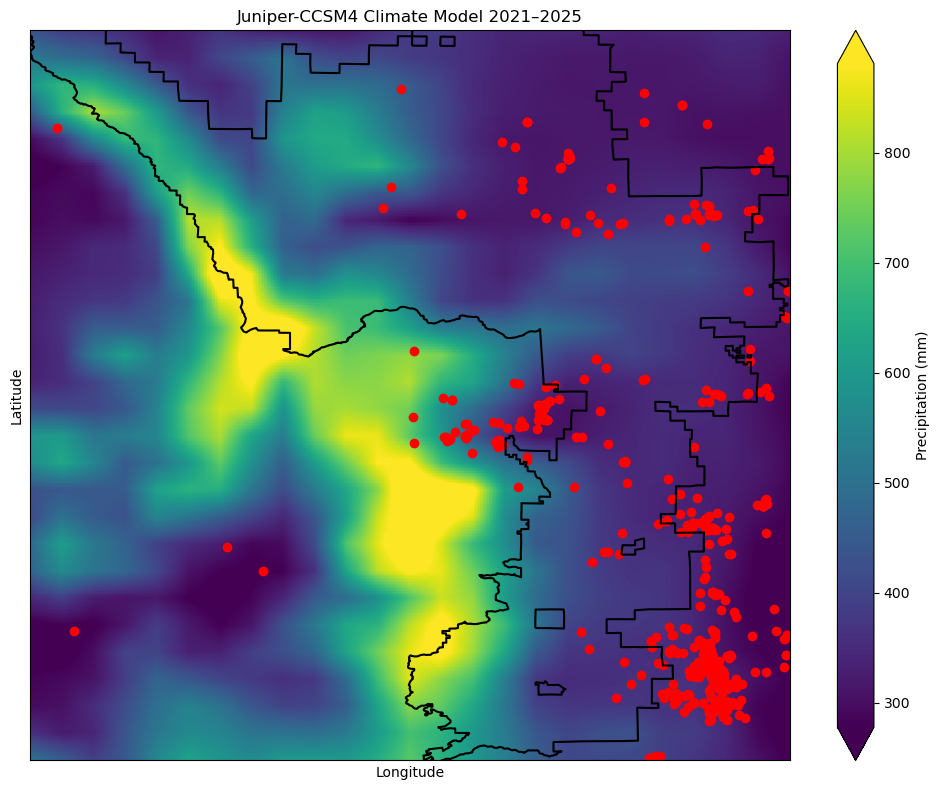

In [57]:
fig, ax = plt.subplots(figsize=(10, 8))

# Plot raster
maca_juniper_2035_da_interp.plot(
    ax=ax,
    cbar_kwargs={"label": "Precipitation (mm)"},
    robust=True
)

# Plot forest boundary without chaining
forest_gdf.boundary.plot(ax=ax, color='black')

juniper_occur_gdf.plot(ax=ax, color = 'red')

# Set plot details separately
ax.set_title('Juniper-CCSM4 Climate Model 2021–2025')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_xticks([])
ax.set_yticks([])

# Ensure aspect ratio won't crash
ax.set_aspect('auto')

plt.tight_layout()
plt.show()

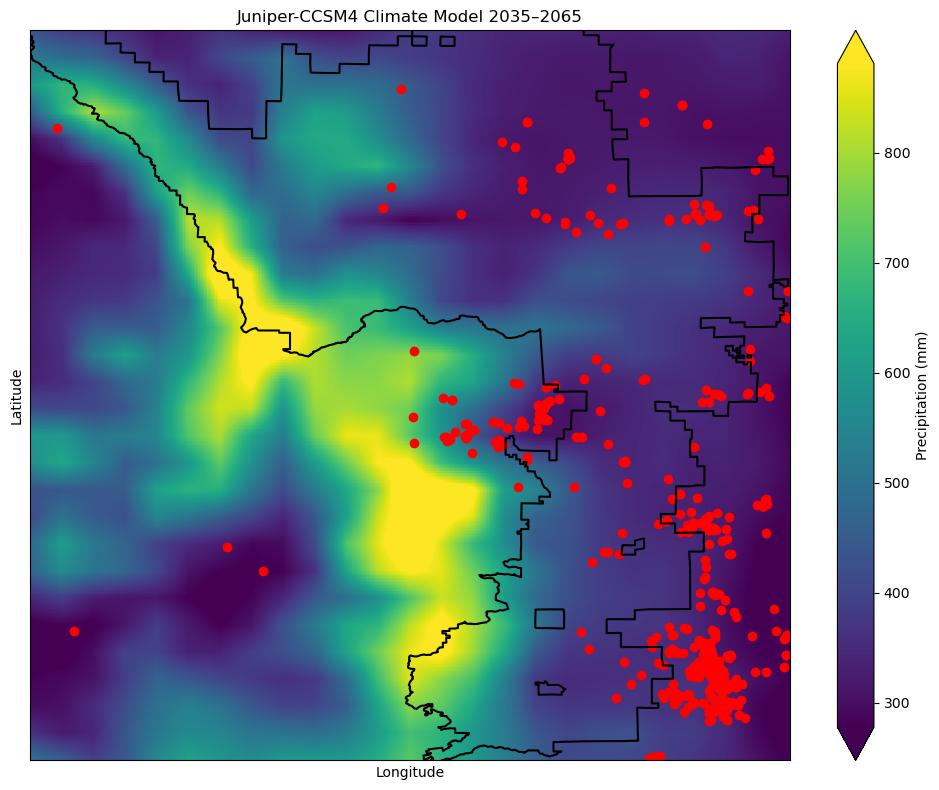

In [58]:
fig, ax = plt.subplots(figsize=(10, 8))

# Plot raster
maca_juniper_2065_da_interp.plot(
    ax=ax,
    cbar_kwargs={"label": "Precipitation (mm)"},
    robust=True
)

# Plot forest boundary without chaining
forest_gdf.boundary.plot(ax=ax, color='black')

juniper_occur_gdf.plot(ax=ax, color = 'red')

# Set plot details separately
ax.set_title('Juniper-CCSM4 Climate Model 2035–2065')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_xticks([])
ax.set_yticks([])

# Ensure aspect ratio won't crash
ax.set_aspect('auto')

plt.tight_layout()
plt.show()

In [59]:
precip_suitability_35 = (maca_juniper_2035_da_interp >= 380) & (maca_juniper_2035_da_interp <= 460)

In [62]:
precip_suitability_65 = (maca_juniper_2065_da_interp >= 380) & (maca_juniper_2065_da_interp <= 460)

In [67]:
# Select your 2D precipitation data slice 
precip_slice_35 = maca_juniper_2035_da_interp 

print("Precipitation min:", precip_slice.min().item())
print("Precipitation max:", precip_slice.max().item())

# Now create suitability mask on this slice
precip_suitability_35 = (precip_slice_35 >= 380) & (precip_slice_35 <= 460)
print("Number of suitable pixels:", precip_suitability_35.sum().item())

Precipitation min: 244.21946021469395
Precipitation max: 1001.7648770073207
Number of suitable pixels: 45383


In [68]:
# Select your 2D precipitation data slice 
precip_slice_65 = maca_juniper_2065_da_interp 

print("Precipitation min:", precip_slice.min().item())
print("Precipitation max:", precip_slice.max().item())

# Now create suitability mask on this slice
precip_suitability_65 = (precip_slice_65 >= 380) & (precip_slice_65 <= 460)
print("Number of suitable pixels:", precip_suitability_35.sum().item())

Precipitation min: 244.21946021469395
Precipitation max: 1001.7648770073207
Number of suitable pixels: 45383


In [69]:
precip_suitability_flipped_35 = 1 - precip_suitability_35

In [70]:
precip_suitability_flipped_65 = 1 - precip_suitability_65

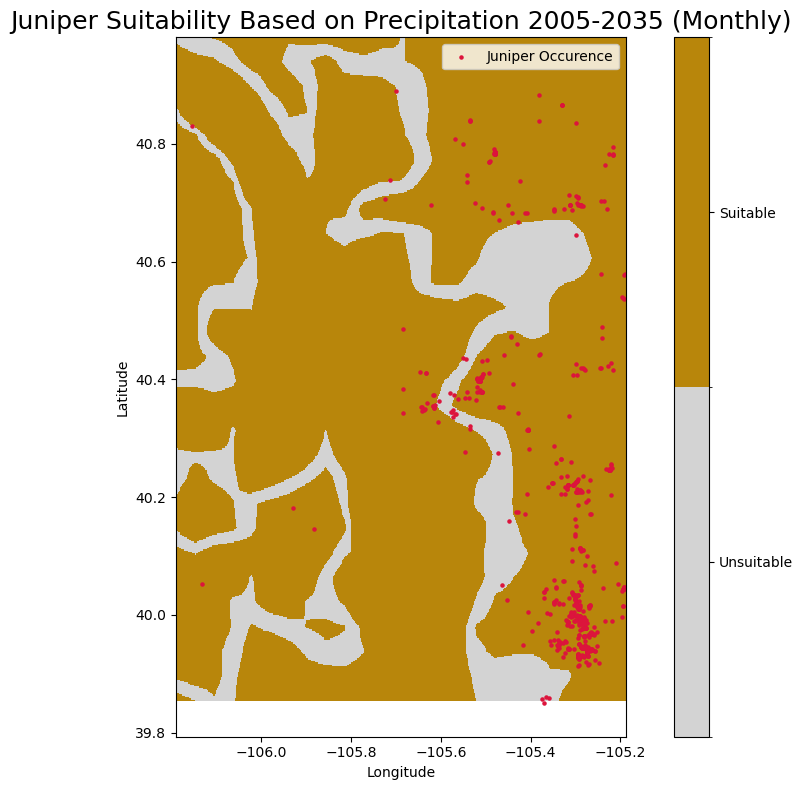

In [65]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


# Define binary colormap for suitability (0 = Unsuitable, 1 = Suitable)
cmap = mcolors.ListedColormap(['lightgray', 'darkgoldenrod'])
norm = mcolors.BoundaryNorm(boundaries=[-0.5, 0.5, 1.5], ncolors=2)


fig, ax = plt.subplots(figsize=(10, 8))
im = precip_suitability_flipped_35.plot.imshow(
    ax=ax,
    cmap=cmap,
    norm=norm,
    add_colorbar=False,
    x='lon',
    y='lat'
)

juniper_occur_gdf.plot(ax=ax, color = 'crimson', markersize=5, label='Juniper Occurence')

# Add colorbar and labels
cbar = plt.colorbar(im, ax=ax, ticks=[0, 1])
cbar.ax.set_yticklabels(['Unsuitable', 'Suitable'])

# Titles and labels
ax.set_title("Juniper Suitability Based on Precipitation 2005-2035 (Monthly)")
ax.title.set_size(18)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.tight_layout()
ax.legend()
plt.show()

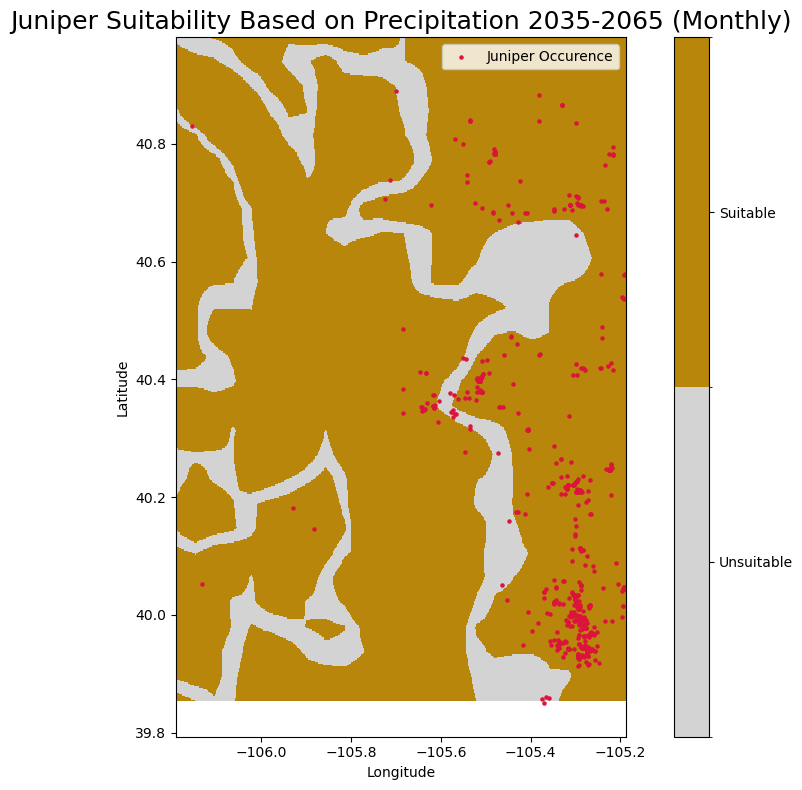

In [72]:
# Define binary colormap for suitability (0 = Unsuitable, 1 = Suitable)
cmap = mcolors.ListedColormap(['lightgray', 'darkgoldenrod'])
norm = mcolors.BoundaryNorm(boundaries=[-0.5, 0.5, 1.5], ncolors=2)


fig, ax = plt.subplots(figsize=(10, 8))
im = precip_suitability_flipped_65.plot.imshow(
    ax=ax,
    cmap=cmap,
    norm=norm,
    add_colorbar=False,
    x='lon',
    y='lat'
)

juniper_occur_gdf.plot(ax=ax, color = 'crimson', markersize=5, label='Juniper Occurence')

# Add colorbar and labels
cbar = plt.colorbar(im, ax=ax, ticks=[0, 1])
cbar.ax.set_yticklabels(['Unsuitable', 'Suitable'])

# Titles and labels
ax.set_title("Juniper Suitability Based on Precipitation 2035-2065 (Monthly)")
ax.title.set_size(18)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.tight_layout()
ax.legend()
plt.show()

In [35]:
print(precip_suitability.dims)
print(precip_suitability.shape)

('lat', 'lon')
(500, 500)


In [36]:
# Prep for harmonizing Part 1 of 1
# Create output directory for this harmonized raster
harmonized_raster_dir = os.path.join(habitat_suitability_data_dir, 'harmonized_rasters')
os.makedirs(harmonized_raster_dir, exist_ok=True) 

In [37]:
clay_suitability = ((clay_processed >= 10) & (clay_processed <= 30))

/opt/conda/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


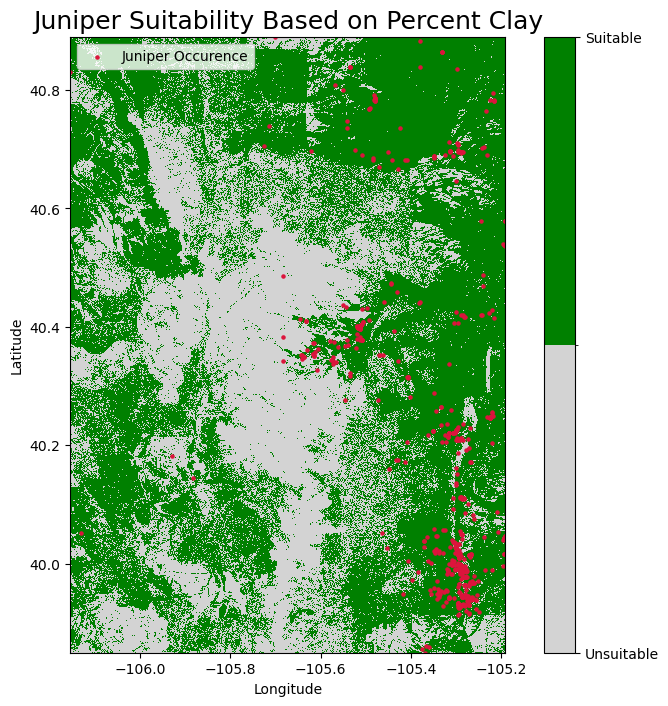

In [38]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

cmap = colors.ListedColormap(['lightgray', 'green'])
bounds = [0, 0.5, 1]
norm = colors.BoundaryNorm(bounds, cmap.N)

fig, ax = plt.subplots(figsize=(10, 8))
im = clay_suitability.plot(ax=ax, cmap=cmap, norm=norm, add_colorbar=False)
juniper_occur_gdf.plot(ax=ax, color = 'crimson', markersize=5, label='Juniper Occurence')
cbar = plt.colorbar(im, ax=ax, ticks=[0, 1])
cbar.ax.set_yticklabels(['Unsuitable', 'Suitable'])
ax.set_title("Juniper Suitability Based on Percent Clay")
ax.title.set_size(18)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend()
plt.show()

In [39]:
sand_suitability = ((sand_processed >= 40) & (sand_processed <= 70))

/opt/conda/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


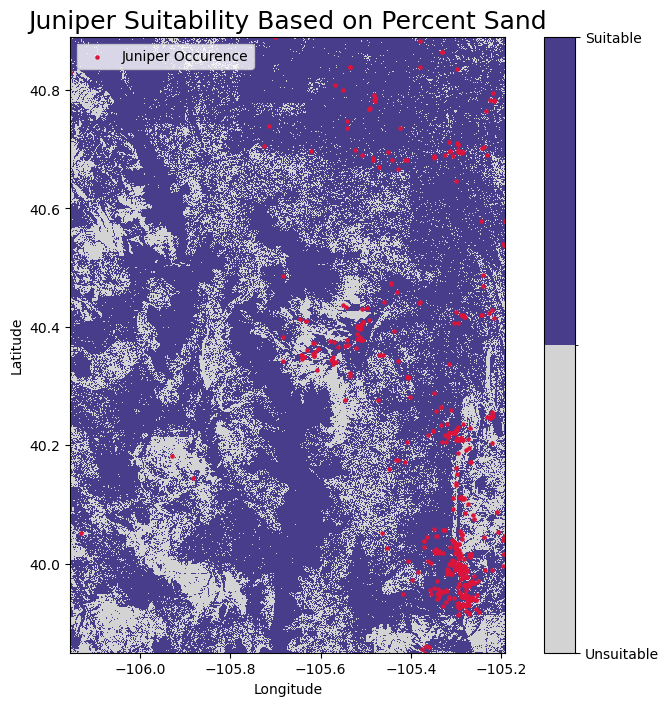

In [40]:
cmap = colors.ListedColormap(['lightgray', 'darkslateblue'])
bounds = [0, 0.5, 1]
norm = colors.BoundaryNorm(bounds, cmap.N)

fig, ax = plt.subplots(figsize=(10, 8))
im = sand_suitability.plot(ax=ax, cmap=cmap, norm=norm, add_colorbar=False)
juniper_occur_gdf.plot(ax=ax, color = 'crimson', markersize=5, label='Juniper Occurence')
cbar = plt.colorbar(im, ax=ax, ticks=[0, 1])
cbar.ax.set_yticklabels(['Unsuitable', 'Suitable'])
ax.set_title("Juniper Suitability Based on Percent Sand")
ax.title.set_size(18)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend()
plt.show()

In [41]:
ph_suitability = (pH_processed >= 5) & (pH_processed <= 8.5)

/opt/conda/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


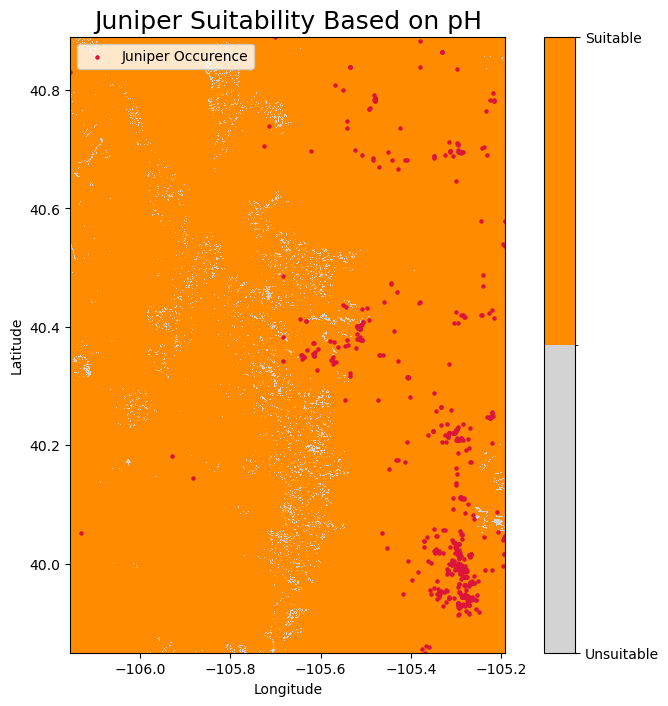

In [42]:
cmap = colors.ListedColormap(['lightgray', 'darkorange'])
bounds = [0, 0.5, 1]
norm = colors.BoundaryNorm(bounds, cmap.N)

fig, ax = plt.subplots(figsize=(10, 8))
im = ph_suitability.plot(ax=ax, cmap=cmap, norm=norm, add_colorbar=False)
juniper_occur_gdf.plot(ax=ax, color = 'crimson', markersize=5, label='Juniper Occurence')
cbar = plt.colorbar(im, ax=ax, ticks=[0, 1])
cbar.ax.set_yticklabels(['Unsuitable', 'Suitable'])
ax.set_title("Juniper Suitability Based on pH")
ax.title.set_size(18)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend()
plt.show()

In [43]:
elev_suitability = ((srtm_juniper_result_da >= 1300) & (srtm_juniper_result_da <= 2900)).astype(int)

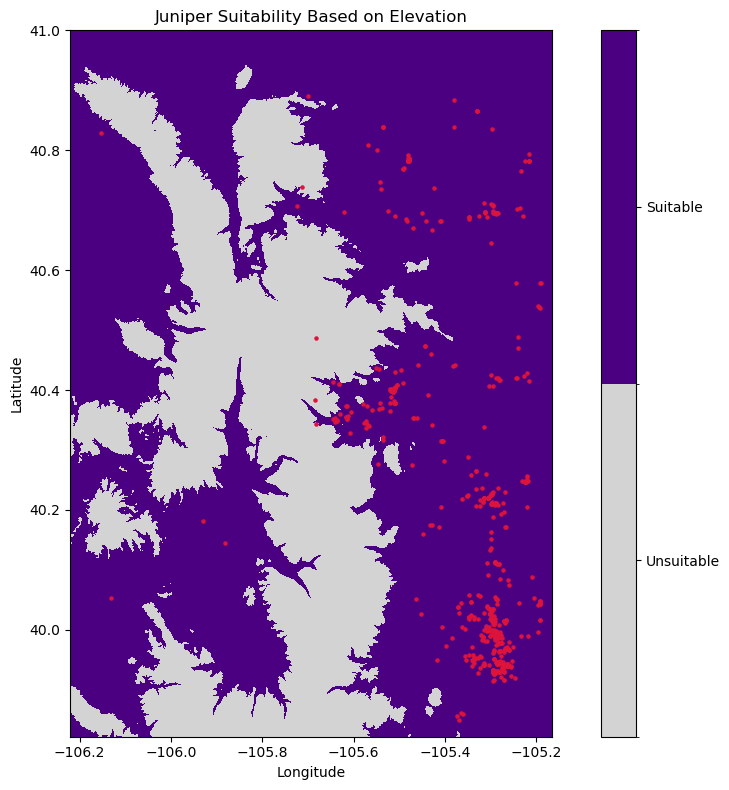

In [44]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

# Define red/green binary colormap
cmap = mcolors.ListedColormap(['lightgray', 'indigo'])
norm = mcolors.BoundaryNorm(boundaries=[-0.5, 0.5, 1.5], ncolors=2)

fig, ax = plt.subplots(figsize=(10, 8))
im = elev_suitability.plot.imshow(
    ax=ax,
    cmap=cmap,
    norm=norm,
    add_colorbar=False,
    x='x',
    y='y'
)

juniper_occur_gdf.plot(ax=ax, color = 'crimson', markersize=5)
cbar = plt.colorbar(im, ax=ax, ticks=[0, 1])
cbar.ax.set_yticklabels(['Unsuitable', 'Suitable'])
ax.set_title("Juniper Suitability Based on Elevation")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.tight_layout()
plt.show()

In [85]:
# Ensure it's binary
precip_suitability_flipped_35 = (precip_suitability_flipped_35 == 1).astype("uint8")

# Set name and export
precip_suitability_flipped_35.name = "precip_suitability"
precip_suitability_flipped_35.rio.to_raster("precip_suitability_35.tif")

In [82]:
# Ensure it's binary
clay_suitability = (clay_suitability == 1).astype("uint8")

# Set name and export
clay_suitability.name = "clay_suitability"
clay_suitability.rio.to_raster("clay_suitability.tif")

In [83]:
# Ensure it's binary
sand_suitability = (sand_suitability == 1).astype("uint8")

# Set name and export
sand_suitability.name = "sand_suitability"
sand_suitability.rio.to_raster("sand_suitability.tif")

In [48]:
# Ensure it's binary
ph_suitability = (ph_suitability == 1).astype("uint8")

# Set name and export
ph_suitability.name = "ph_suitability"
ph_suitability.rio.to_raster("ph_suitability.tif")

In [49]:
# Ensure it's binary
elev_suitability = (elev_suitability == 1).astype("uint8")

# Set name and export
elev_suitability.name = "elev_suitability"
elev_suitability.rio.to_raster("elev_suitability.tif")

In [84]:
# Ensure it's binary
precip_suitability_flipped_65 = (precip_suitability_flipped_65 == 1).astype("uint8")

# Set name and export
precip_suitability_flipped_65.name = "precip_suitability"
precip_suitability_flipped_65.rio.to_raster("precip_suitability_65.tif")